In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pymoo.optimize import minimize
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.operators.sampling.lhs import LHS
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga3 import NSGA3
from pymoo.algorithms.moo.nsga2 import NSGA2
from ax.service.ax_client import AxClient, ObjectiveProperties

os.chdir('..')
from src.plotters import parallel_plot, plot_pareto_front

/Users/gbemidebe/miniconda3/envs/ActiveLearn/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")


# The Problem

In [3]:
def polymer_properties(x1, x2, x3, x4, x5, x6, x7):
    """
    Calculates the strength and biodegradability properties of a polymer based
    on a set of given input parameters.

    Parameters:
    x1 (float): volume fraction of monomer 1. Range: [0.0, 1.0].
    x2 (float): volume fraction of monomer 2: [0.0, 1.0].
    x3 (float): volume fraction of monomer 3: [0.0, 1.0].
    x4 (float): volume fraction of monomer 4: [0.0, 1.0].
    x5 (float): volume fraction of monomer 5: [0.0, 1.0].
    x6 (float): the polymer extrusion rate. Range: [0.01, 0.1].
    x7 (float): the processsing temperature. Range: [120.0, 200.0].

    Returns:
    dict: calculated strength and biodegradability properties of polymer in form:
          {
              "strength": float,
              "biodegradability": float
          }
    credit:
    https://honegumi.readthedocs.io/en/latest/tutorials/mobo-tutorial.html
    """
    strength = float(
        np.exp(-(50*(x1-0.5)**2)) +
        np.exp(-(5*(x2-0.4)**2)) -
        0.8*x3 +
        np.exp(-(300*(x4-0.1)**2)) -
        0.3*x5**2 +
        np.exp(-(2000*(x6-0.025)**2)) +
        1/(1+np.exp(-(x7-137)/15))
    )

    biodegradability = float(
        -1/(1+np.exp(-(x1-0.1)/0.1)) + 1 +
        -1/(1+np.exp(-(x2-0.3)/0.1)) + 1 +
        x3**2 +
        x4 +
        1/(1+np.exp(-(x5-0.7)/0.075)) +
        10*x6 +
        -(x7/200)**2+1
    )

    return {"strength" : strength*25, "biodegradability" : biodegradability*5}

# 1. NSGA-II

In [4]:
class opt_task(ElementwiseProblem):
    def __init__(self):
        super().__init__(n_var=7, n_obj = 2, n_constr = 0, vtype=float)

        self.xl = np.array([0.00, 0.00, 0.00, 0.00, 0.00, 0.01, 120.00])
        self.xu = np.array([1.00, 1.00, 1.00, 1.00, 1.00, 0.10, 200.00])
    
    def _evaluate(self, X, out):

        # objective functions
        results = polymer_properties(x1 = X[0], x2 = X[1], x3 = X[2], x4 = X[3], x5 = X[4], x6 = X[5], x7 = X[6])
        f3 = results['strength']
        f4 = results['biodegradability'] 

        out["F"] = [-f3, -f4]

problem = opt_task()
sampling = LHS()
Salgorithm = NSGA2(pop_size=200)
result = minimize(problem, Salgorithm, ('n_gen', 600), 
                  sampling=sampling, seed=1, save_history=True, verbose=False)


Compiled modules for significant speedup can not be used!
https://pymoo.org/installation.html#installation

To disable this warning:
from pymoo.config import Config
Config.warnings['not_compiled'] = False



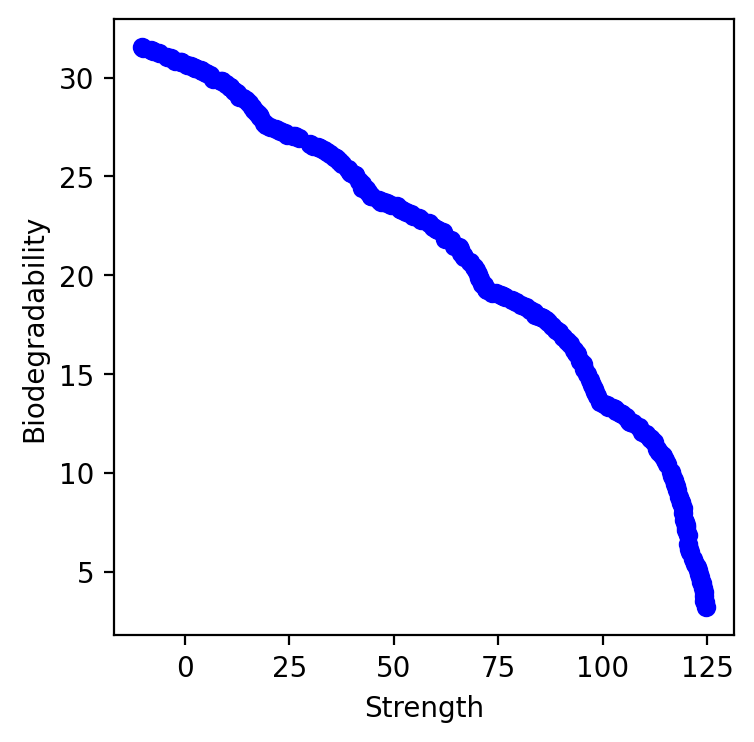

In [5]:
plot_pareto_front(result)

/Users/gbemidebe/miniconda3/envs/ActiveLearn/lib/python3.8/site-packages/paxplot/core.py:842: Warning: The function you have called (subplots_adjust) is not officially supported by Paxplot, but it may still work. Report issues to https://github.com/kravitsjacob/paxplot/issues
  warnings.warn(


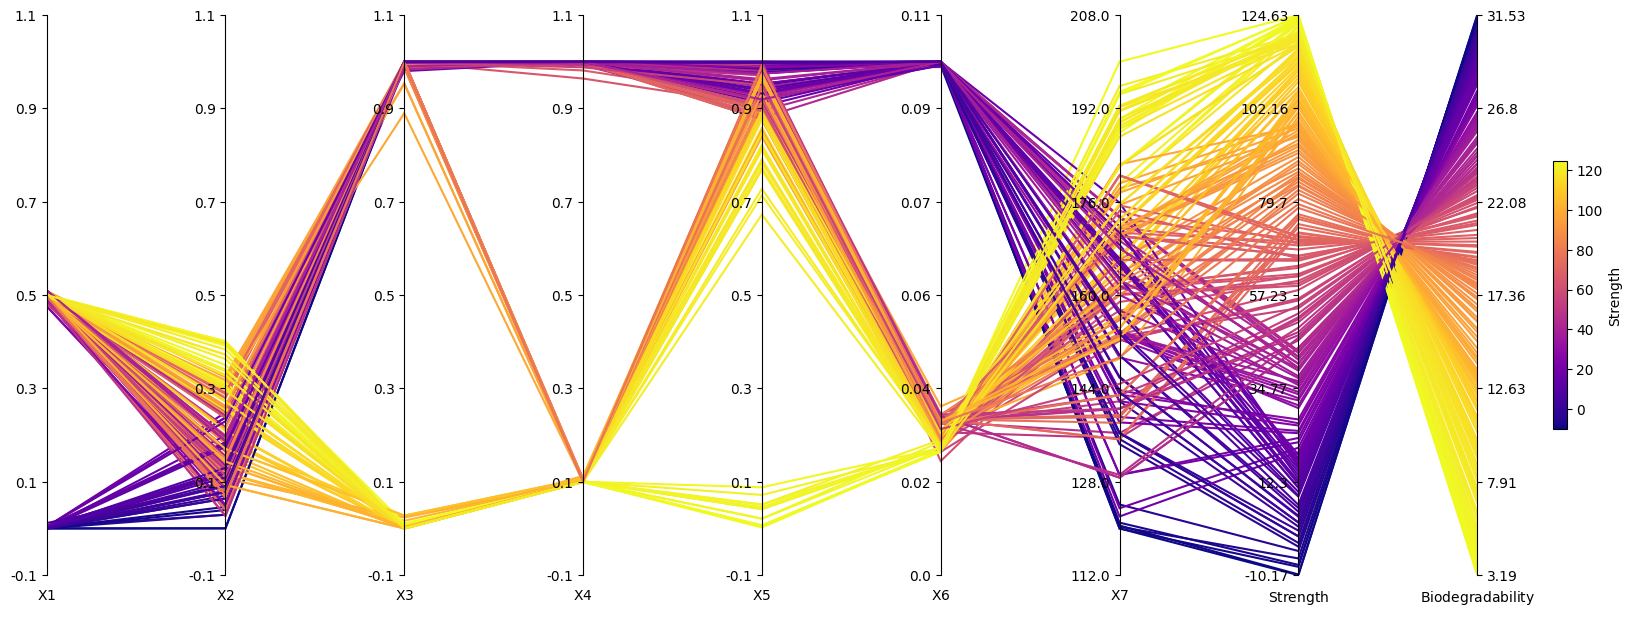

In [6]:
parallel_plot(result)

# 2. NSGA-III

In [7]:
# create the reference directions to be used for the optimization
ref_dirs = get_reference_directions("das-dennis", 2, n_partitions=12)

# create the algorithm object
NSGA3algorithm = NSGA3(pop_size=200,
                  ref_dirs=ref_dirs)

# execute the optimization
res = minimize(problem,
               NSGA3algorithm,
               sampling = sampling,
               seed=1,
               termination=('n_gen', 600), save_history=True, verbose=False)

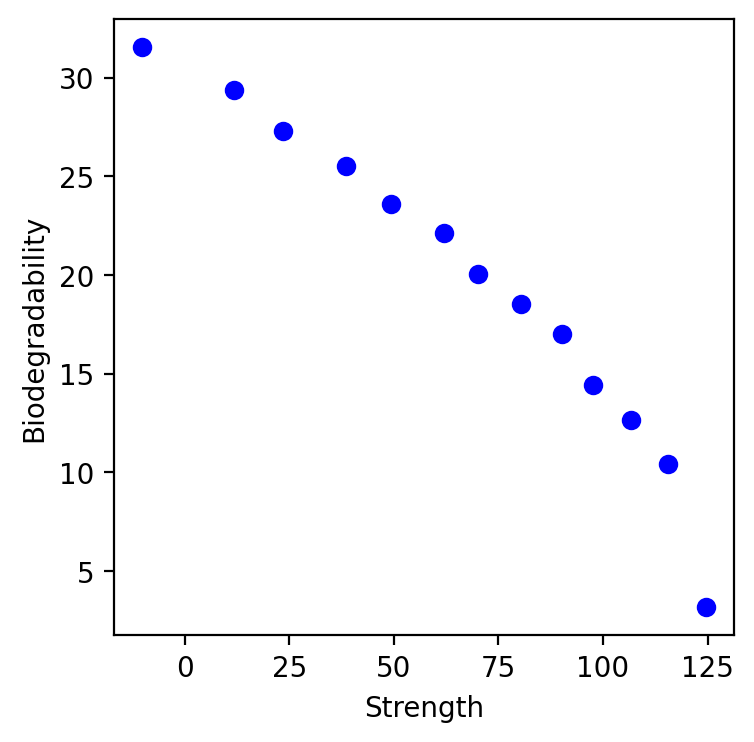

In [8]:
plot_pareto_front(res)

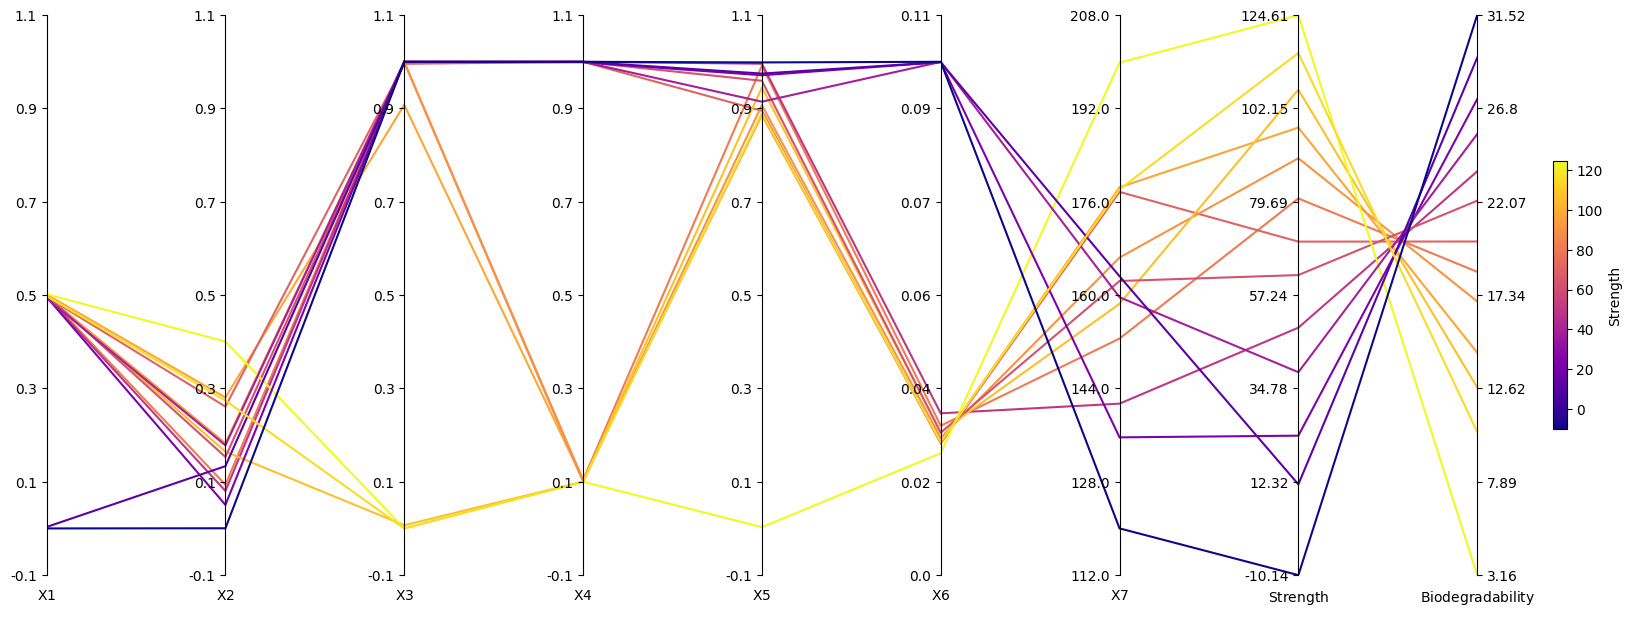

In [9]:
parallel_plot(res)

# 2. Bayesian optimization

credit: https://honegumi.readthedocs.io/en/latest/tutorials/mobo-tutorial.html

In [10]:
obj1_name = "strength" # CHANGE: add name of first objective
obj2_name = "biodegradability" # CHANGE: add name of first objective


# CHANGE: remove the moo_branin dummy objective function, we will use the above function

# CHANGE: update the total quantity for the composition constraint
total = 1.0

# CHANGE: add the historical data that was pulled from the literature
X_train = pd.DataFrame(
    [
        {"x1": 0.3, "x2": 0.2, "x3": 0.1, "x4": 0.0, "x5": 0.4, "x6": 0.05, "x7": 150.0},
        {"x1": 0.0, "x2": 0.0, "x3": 0.3, "x4": 0.7, "x5": 0.0, "x6": 0.1, "x7": 160.0},
        {"x1": 0.2, "x2": 0.2, "x3": 0.2, "x4": 0.2, "x5": 0.2, "x6": 0.09, "x7": 184.0},
    ]
)

# CHANGE: calculate the y_train values using the polymer_properties function
y_train = [polymer_properties(**row[1]) for row in X_train.iterrows()]

# Define the number of training examples
n_train = len(X_train)

ax_client = AxClient(random_seed=12345) # CHANGE: add random seed for reproducibility

ax_client.create_experiment(
    parameters=[
        {"name": "x1", "type": "range", "bounds": [0.0, 1.0]}, # CHANGE: update parameter
        {"name": "x2", "type": "range", "bounds": [0.0, 1.0]}, # CHANGE: update parameter
        {"name": "x3", "type": "range", "bounds": [0.0, 1.0]}, # CHANGE: add new parameter
        {"name": "x4", "type": "range", "bounds": [0.0, 1.0]}, # CHANGE: add new parameter
        {"name": "x5", "type": "range", "bounds": [0.0, 1.0]}, # CHANGE: add new parameter
        {"name": "x6", "type": "range", "bounds": [0.01, 0.1]}, # CHANGE: add new parameter
        {"name": "x7", "type": "range", "bounds": [120.0, 200.0]}, # CHANGE: add new parameter
    ],
    objectives={
        obj1_name: ObjectiveProperties(minimize=False, threshold=70.0), # CHANGE: set minimize to False and change threshold
        obj2_name: ObjectiveProperties(minimize=False, threshold=0.0), # CHANGE: set minimize to False and change threshold
    },
    parameter_constraints=[
        f"x1 + x2 + x3 + x4 <= {total}", # CHANGE: update composition constraint
    ],
)

# Add existing data to the AxClient
for i in range(n_train):
    parameterization = X_train.iloc[i].to_dict()

    ax_client.attach_trial(parameterization)
    ax_client.complete_trial(trial_index=i, raw_data=y_train[i])


for _ in range(35): # CHANGE: increase number of trials

    parameterization, trial_index = ax_client.get_next_trial()

    # CHANGE: pull all added parameters from the parameterization
    x1 = parameterization["x1"]
    x2 = parameterization["x2"]
    x3 = parameterization["x3"]
    x4 = parameterization["x4"]
    x5 = total - (x1 + x2 + x3 + x4) # CHANGE: update composition constraint
    x6 = parameterization["x6"]
    x7 = parameterization["x7"]

    results = polymer_properties(x1, x2, x3, x4, x5, x6, x7) # CHANGE: switch to polymer function
    ax_client.complete_trial(trial_index=trial_index, raw_data=results)

pareto_results = ax_client.get_pareto_optimal_parameters()

[INFO 05-15 23:09:54] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.
[WARNING 05-15 23:09:54] ax.service.ax_client: Random seed set to 12345. Note that this setting only affects the Sobol quasi-random generator and BoTorch-powered Bayesian optimization models. For the latter models, setting random seed to the same number for two optimizations will make the generated trials similar, but not exactly the same, and over time the trials will diverge more.
[INFO 05-15 23:09:54] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter x1. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 05-15 23:09:54] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter x2. If that is not the expected v

In [11]:
p_op = ax_client.get_pareto_optimal_parameters()

# parse p_op values to get parameters and values
p_op_index = list(p_op.keys())
p_op_params = [p_op[i][0] for i in p_op_index]
p_op_values = [p_op[i][1][0] for i in p_op_index]

# organize the results into a dataframe
pareto_results = pd.DataFrame(p_op_params, columns=["x1", "x2", "x3", "x4", "x5", "x6", "x7"])
pareto_results["strength"] = [v["strength"] for v in p_op_values]
pareto_results["biodegradability"] = [v["biodegradability"] for v in p_op_values]
pareto_results.index = p_op_index
display(pareto_results.round(2))

[INFO 05-15 23:10:54] ax.modelbridge.torch: The observations are identical to the last set of observations used to fit the model. Skipping model fitting.


,x1,x2,x3,x4,x5,x6,x7,strength,biodegradability
18,0.04,0.08,0.0,0.12,0.74,0.02,169.24,78.82,14.35
21,0.47,0.22,0.0,0.10,0.45,0.03,160.30,115.19,7.22
26,0.47,0.37,0.0,0.10,0.47,0.03,166.81,120.41,5.15
27,0.52,0.04,0.0,0.10,0.45,0.03,167.79,108.48,8.06
29,0.39,0.00,0.0,0.11,0.47,0.03,159.19,92.59,9.18
30,0.49,0.25,0.0,0.10,0.40,0.03,173.44,120.02,6.22
31,0.00,0.07,0.0,0.12,0.87,0.03,157.43,76.69,16.17
33,0.01,0.19,0.0,0.12,0.77,0.03,161.64,85.16,13.15
35,0.47,0.04,0.0,0.10,0.16,0.03,165.48,107.66,8.27
37,0.03,0.25,0.0,0.12,0.74,0.03,163.64,88.33,11.22


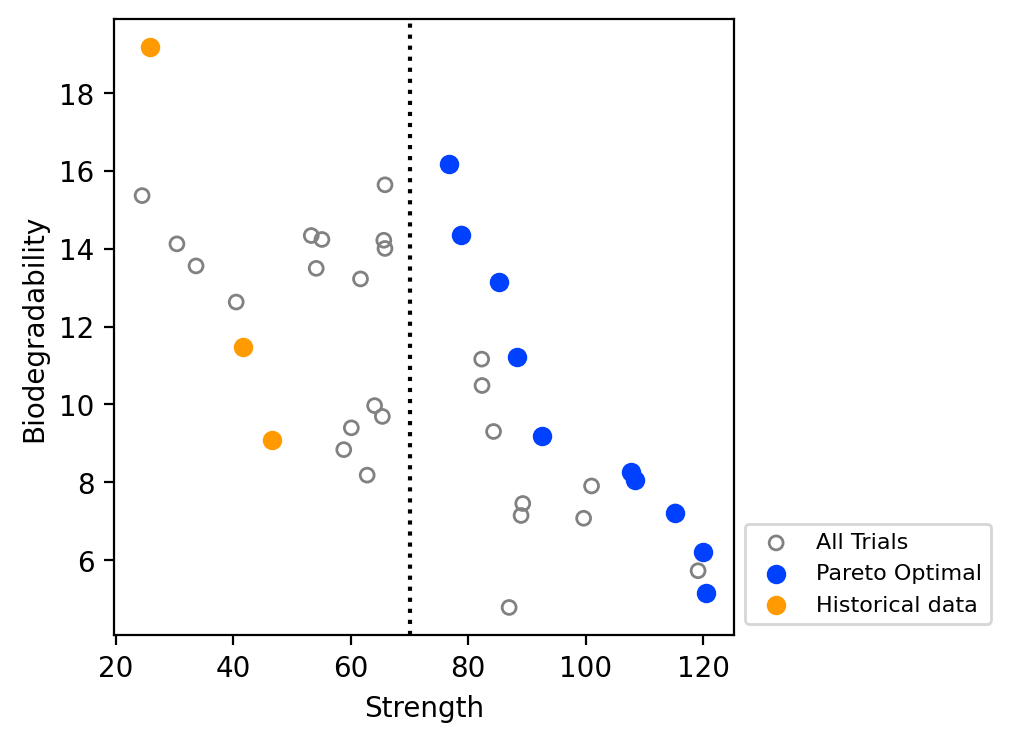

In [12]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=200)

all_trials = ax_client.get_trials_data_frame()
ax.scatter(
    all_trials["strength"],
    all_trials["biodegradability"],
    color='#818180',
    facecolor='none',
    s=25,
    label='All Trials'
)
ax.scatter(pareto_results["strength"], pareto_results["biodegradability"], color='#0041FF', label='Pareto Optimal')
historical = np.array([[d['strength'][0], d['biodegradability'][0]] for d in y_train])
ax.scatter(historical[:,0], historical[:,1], color='#FF9A00', label='Historical data')
ax.axvline(70, ls=':', color='k')
ax.set_xlabel("Strength")
ax.set_ylabel("Biodegradability")
ax.legend(facecolor='w', fontsize=8, loc='center left', bbox_to_anchor=(1, 0.1))
plt.show()

# Compare the Results

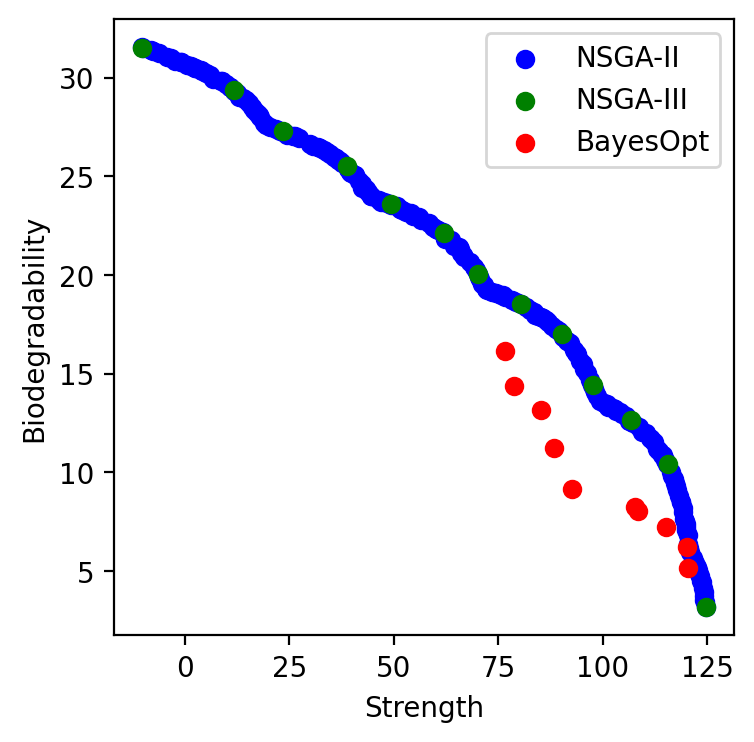

In [13]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=200)

ax.scatter(-result.F[:,0], -result.F[:,1], color="blue", label="NSGA-II")
ax.scatter(-res.F[:,0], -res.F[:,1], color="green", label="NSGA-III")
ax.scatter(pareto_results["strength"], pareto_results["biodegradability"], color="red", label="BayesOpt")
ax.set_xlabel("Strength")
ax.set_ylabel("Biodegradability")
ax.legend()